In [9]:
from math import exp,log
import numpy as np
np.random.seed(0)
from os import sys
import numpy as np
from scipy.special import lambertw
from scipy.optimize import  bisect,newton
import scipy.optimize as optimize

sys.path.append("./lib_point_proc")

from basic_models import IntensityBasedPointProcessModel
import utils
from collections import defaultdict

class HTRm (IntensityBasedPointProcessModel) :
    
    def __init__(self,r_0=0.0,a_s=0.0,b_s=0.0,T_s=[],a_h=0.0,b_h=0.0,kappa=0.0,
                 all_realizations=defaultdict(list),cur_realization_key=""):

        self.r_0 = r_0
        self.a_s = a_s
        self.b_s = b_s
        self.a_h = a_h
        self.b_h = b_h
        self.kappa = kappa
        self.T_s = T_s
        
        self.all_realizations = all_realizations
        self.cur_realization_key = cur_realization_key
        
        self.__d_lam_j  =0.0
        self.__lam_j_1  =0.0
        
    def lamda_sale(self,t):
        
        T   = self.get_cur_realization()
        T_s = self.T_s
        
        s   = 0
        for j in range(0,len(T_s)):
            if(T_s[j]<=t):
                s += (t-T_s[j])*exp(- self.b_s*(t-T_s[j]))

        return self.r_0 * (1 + self.a_s * s)

    def Lamda_sale(self,t):
        T   = self.get_cur_realization()
        T_s = self.T_s
        a_s = self.a_s
        b_s = self.b_s
        r_0 = self.r_0
        t_0 = T[0]

        s = 0
        d = 1.0/b_s

        for i in range(0,len(T_s)):
            if(T_s[i]<=t):
                h = max(0, t_0 - T_s[i])
                g = max(0, t   - T_s[i])
                s = s + ( exp(-b_s*h)*(h + d) ) - ( exp(-b_s*g)*( t - T_s[i] + d)  )
        s = r_0*(t-t_0) + (r_0*a_s*d) * s

        return s


    def lamda_excite(self,t,L_t, L_T):

        a_h = self.a_h
        b_h = self.b_h
        T   = self.get_cur_realization()

        s   = 0
        for j in range(0,len(T)):
            if(T[j]<t):
                try:
                    s += exp(-b_h*(L_t-L_T[j]))
                except:
                    print b_h, L_t, L_T[j]

        return (1 + a_h * s)
        

    def Omega(self,t,L_t, L_T):
        
        a_h = self.a_h
        b_h = self.b_h
        T   = self.get_cur_realization()
        
        s = 0
        for j in range(0,len(T)):
            if(T[j]<t):
                try:
                    s =  s + 1 - exp(-b_h*(L_t- L_T[j]))
                except:
                    print "error:" + str((L_t, L_T[j], b_h, T, L_T ))

        return L_t+ (float(a_h)/b_h)*s

    
    def lamda_pre(self,t,O_t,O_T):
        
        T     =  self.get_cur_realization()
        kappa =  self.kappa
        n_t   = self.N_t(t)

        if(len(T) ==0 or n_t ==0):

            return 1.0
        if(n_t == 1 and t == T[0]):
            print "n_t 1"
            return kappa*(1.0)
        d = O_t-O_T[n_t-1]
        if(d<0):
            print "delta "+ str(d)
        return kappa * utils.safe_pow(O_t-O_T[n_t-1],kappa-1) 


    def Psi(self,t,O_t,O_T):
        
        T     =  self.get_cur_realization()
        kappa =  self.kappa

        n_t  = self.N_t(t)
        if(len(T)==0 or n_t ==0):
            return 0.0

        s = 0    
        for j in range(1,n_t-1):
            #print j,n_t,len(T),len(O_T)
            s += utils.safe_pow(O_T[j+1] - O_T[j],kappa)

        ret = s + utils.safe_pow(O_t - O_T[n_t-1],kappa)

        return ret
    

    def lamda(self,t):


        T = self.get_cur_realization()
        
        L_T = map(self.Lamda_sale,T)
        O_T = []
        for i in range(len(T)):
            O_T.append(self.Omega(T[i],L_T[i], L_T))

        L_t = self.Lamda_sale(t)
        O_t = self.Omega(t, L_t, L_T)
        
        return self.lamda_sale(t)*self.lamda_excite(t,L_t,L_T)*self.lamda_pre(t,O_t,O_T)
    

    def Lamda(self):
        raise("Not Implemented")
        
    def log_lamda_all(self,t,L_T,O_T):
        
        T   =  self.get_cur_realization()
        
        L_t = self.Lamda_sale(t)

        O_t = self.Omega(t,L_t, L_T)

        l_sal_t = self.lamda_sale(t)
        l_exc_t = self.lamda_excite(t,L_t,L_T)
        l_pre_t = self.lamda_pre(t,O_t,O_T)


        if(l_sal_t <0 or l_exc_t<0 or l_pre_t <0):
            print "-ve" + str((l_sal_t,l_exc_t, l_pre_t))

        if(l_sal_t == 0 or l_exc_t==0 or l_pre_t == 0):
            print "zero" + str((l_sal_t,l_exc_t, l_pre_t))

        if(l_sal_t ==0):
            print "l_sal_t=0"
            l_sal_t = 1.0 
        if(l_exc_t ==0):
            print "l_exc_t=0"
            l_exc_t = 1.0
        if(l_pre_t ==0):
            print "l_pre_t=0"
            l_pre_t = 1.0


        return log(l_sal_t) + log(l_exc_t ) + log(l_pre_t)
    
    def log_likelihood_1(self):
        
        T     =  self.get_cur_realization()

        t_max = T[-1]
        L_T = map(self.Lamda_sale,T)
        
        O_T = []
        for i in range(len(T)):
            O_T.append(self.Omega(T[i],L_T[i],L_T))

        L_t_mx = self.Lamda_sale(t_max)
        O_t_mx = self.Omega(t_max, L_t_mx, L_T) 

        ll = 0
        for t in T:
            l = self.log_lamda_all(t, L_T, O_T)
            ll += l

        return ll - self.Psi(t_max, O_t_mx, O_T)

    def log_likelihood(self):
        
        T     =  self.get_cur_realization()
        t_max = T[-1]
        
        a_h   = self.a_h
        b_h   = self.b_h

        kappa = self.kappa

        L_T     = map(self.Lamda_sale, T)
        L_t_max = L_T[-1]

        sale_s = 0
        for t in T:
            sale_s += log(self.lamda_sale(t))

        n = len(T)
        A = np.zeros(n)
        hawk_s = 0
        for j in range(0,n-1):

            A[j+1] = (1+A[j])*exp(-b_h*(L_T[j+1] - L_T[j]))
            hawk_s += log(1+ a_h*A[j])

        hawk_s += log(1+a_h*A[n-1])

        hawk_s_1= 0
        for j in range(0,n):
            hawk_s_1 += log(self.lamda_excite(T[j],L_T[j],L_T))

        pre_s = 0
        D_omg = np.zeros(n)
        s1 = 0
        s2 = 0


        for j in range(1,n-1):
            D_omg[j] = L_T[j+1] - L_T[j] + (a_h/b_h)*(1 + A[j] - A[j+1])
            '''
            if(L_T[j+1]-L_T[j]<0):
                print L_T[j+1],L_T[j]
            if(1 + A[j] - A[j+1]<0):
                print  A[j],A[j+1]
            '''    
            if(D_omg[j]<0):
                print"D_omg"+ str((D_omg[j],L_T[j+1],L_T[j],A[j],A[j+1]))
                D_omg[j]=1.0
            if(D_omg[j]==0):
                D_omg[j]=1.0
            s1 += log(D_omg[j])
            s2 += (D_omg[j])**(kappa)

        pre_s = (n-1)*log(kappa) + (kappa-1)* s1 - s2
        # O_T[1] = L_T[1]  eqn 18

        ex = L_t_max - L_T[-1] + (a_h/b_h)*(1+ A[-1])*(1- exp(-b_h*(L_t_max- L_T[-1]))) 

        #print sale_s, hawk_s, pre_s, L_T[1]**kappa, ex**kappa
        #print hawk_s_1
        return sale_s + hawk_s + pre_s - L_T[1]**kappa - ex**kappa
    
    def fit_ml e_params(self,tol=1e-15):
        
        def obj(x):
            if(min(x)<0):
                return 10000000
            self.r_0  = x[0]
            self.a_s  = x[1]
            self.b_s  = x[2]
            self.a_h  = x[3]
            self.b_h  = x[4]
            self.kappa = x[5]
            
            l = -self.log_likelihood()
            return l
                

        bnds = ((0.00001, 10.0), (0.00001,10.0), (0.00001,10.0),(0.00001,10.0),(0.00001,10.0),(0.00001,10.0))
        res = optimize.minimize(obj, x0= (0.00001,0.00001,0.00001,0.00001,0.00001,0.00001),
                                method="L-BFGS-B",bounds=bnds,tol=tol)
         
        self.r_0  = res.x[0]
        self.a_s  = res.x[1]
        self.b_s  = res.x[2]
        self.a_h  = res.x[3]
        self.b_h  = res.x[4]
        self.kappa = res.x[5]
        
        return res
    

    
    #def fit_map_params(self):
    def fit_em_map_params(self,max_iters=50,threshold=0.01):
        from scipy.special import psi
        from scipy.optimize import  bisect,newton
        from pymc import Gamma,MCMC
        import pymc
                
        def __converged(c_mu, p_mu,tol=0.01):

            for k in c_mu.keys():
                if(abs(c_mu[k]-p_mu[k])>tol):
                    return False

            return True


        def __nu_update_func(x):

            if(x<=0.0):
                x = 0.00001
            return log(x) - psi(x) - log(mu_c[cur_k]) + e_log_theta_dict[cur_k]

        T = self.get_cur_realization()

        mu_p = {"a_s":1.0,  "b_s":1.0,  "r_0":1.0,"a_h":1.0, "b_h":2.0,  "kappa":1.0}
        nu_p = {"a_s":1.0,  "b_s":1.0,  "r_0":1.0,"a_h":1.0,  "b_h":1.0,  "kappa":1.0}

        mu_c = mu_p.copy()
        nu_c = mu_p.copy()
        
        cur_k = "a_s"
        e_log_theta_dict = {}

        param_names = ["a_s","b_s","r_0","a_h","b_h","kappa"]

        i = 0

        ll_ar = []

        while i < max_iters :

            a_s = Gamma( 'a_s', alpha=nu_c["a_s"], beta=nu_c["a_s"]/mu_c["a_s"])
            b_s = Gamma( 'b_s', alpha=nu_c["b_s"], beta=nu_c["b_s"]/mu_c["b_s"])
            r_0 = Gamma( 'r_0', alpha=nu_c["r_0"], beta=nu_c["r_0"]/mu_c["r_0"])

            a_h = Gamma( 'a_h', alpha=nu_c["a_h"], beta=nu_c["a_h"]/mu_c["a_h"])
            b_h = Gamma( 'b_h', alpha=nu_c["b_h"], beta=nu_c["b_h"]/mu_c["b_h"])

            kappa = Gamma( 'kappa', alpha=nu_c["kappa"], beta=nu_c["kappa"]/mu_c["kappa"])



            c = (mu_c["a_h"]+mu_c["b_h"])
            p_h = {"a_s":mu_c["a_s"], "b_s":mu_c["b_s"], "r_0":mu_c["r_0"], "kappa":mu_c["kappa"], 
                   "a_h":mu_c["a_h"]/c, "b_h":mu_c["b_h"]/c, "T_s":T_s}

            t_max = T[-1]

            @pymc.stochastic(observed=True)
            def htrm_stochastic(value=T,a_s =a_s, b_s=b_s,r_0=r_0, 
                                  a_h=a_h, b_h = b_h, kappa =kappa ):

                #params = {"a_s":a_s, "b_s":b_s, "r_0":r_0, "a_h":a_h,"b_h":b_h, "kappa":kappa, "T_s":T_s,"t_0":t_0}
                self.a_s = a_s
                self.b_s = b_s
                self.r_0 = r_0
                self.a_h = a_h
                self.b_h = b_h
                self.kappa = kappa
                
                l      = self.log_likelihood_1()
                return l


            model = MCMC([htrm_stochastic,a_s,b_s,r_0,a_h,b_h,kappa])
            #model.use_step_method(pymc.Metropolis, a_s, proposal_sd=1., proposal_distribution='Normal')

            model.sample(iter=1000, burn=100,thin=80)
            mu_p = mu_c.copy()
            nu_p = nu_c.copy()

            for p in param_names:
                samples = model.trace(p)[:]
                mu_c[p] = samples.mean()
                e_log_theta_dict[p] = np.array(map(log,samples)).mean()

            for k in mu_c.keys():
                cur_k = k
                #nu[cur_mu] = bisect(func2,0.01, 100000)
                nu_c[cur_k] = newton(__nu_update_func,nu_p[cur_k],tol=0.0001,maxiter=10000)

            c = (mu_c["a_h"]+mu_c["b_h"])
            print "\n iteration: "+ str(i)

            print mu_c["a_s"],mu_c["b_s"],mu_c["r_0"],mu_c["a_h"],mu_c["b_h"],mu_c["kappa"],mu_c["a_h"]/c, mu_c["b_h"]/c
            mu_c["a_h"] /=c
            mu_c["b_h"] /=c

            p_h = {"a_s":mu_c["a_s"], "b_s":mu_c["b_s"], "r_0":mu_c["r_0"], "kappa":mu_c["kappa"], 
                   "a_h":mu_c["a_h"]/c, "b_h":mu_c["b_h"]/c, "T_s":T_s}

            self.a_s = mu_c["a_s"]
            self.b_s = mu_c["b_s"]
            self.r_0 = mu_c["r_0"]
            self.a_h = mu_c["a_h"]
            self.b_h = mu_c["b_h"]
            self.kappa = mu_c["kappa"]
            
            if(__converged(mu_c,mu_p,0.01)):
                print "Converged"
                break
            i+=1


    def sample(self,t_0=0,t_max=1000,n_samples=100):
        
        def __func(t):

            lam = self.Lamda_sale(t)

            return lam - lam_j_1 - d_lam_j   


        def __gradient(t):
            r_0  = self.r_0
            a_s  = self.a_s
            b_s  = self.b_s

            s   = 0
            for j in range(0,len(T_s)):
                if(T_s[j]<=t):
                    s += (t-T_s[j])*exp(-b_s*(t-T_s[j]))

            return r_0 * (1 + a_s * s)
        
        T       = np.zeros(n_samples)
        self.all_realizations["cur_sample"]= T
        self.cur_realization_key = "cur_sample"
        

        T_s  = self.T_s

        d_lam_j = 0.0

        psi     = [0]
        omg     = [0]

        b_h     = self.b_h
        a_h     = self.a_h
        kappa   = self.kappa
        
        T[0]    = t_0  #???

        d_psi = np.random.exponential(1.0, n_samples+1)

        d_psi[0]= 0

        d_omg = d_psi**(1.0/kappa)

        d_lam = np.zeros(len(d_omg))

        d_lam[0] = 0.0

        B = a_h/b_h

        for j in range(1,n_samples):

            lam_j_1  = self.Lamda_sale(T[j-1])

            d_lam[j]     = d_omg[j] - B + (1.0/b_h) *lambertw( b_h * B * exp(-b_h * ( d_omg[j]-B) ) ).real 
            B = (a_h/b_h) * ( 1 + B * exp(-b_h * d_lam[j]) )
            d_lam_j = d_lam[j]

            #t = bisect(self.__func,T[j-1],T[j-1]+1000)

            t = newton(__func,T[j-1], tol=0.0001,maxiter=100000)
            T[j] = t
            #T.sort() # to find the t_j in the neighbourhood of t_{j-1} 
        return T
    
    def next_k_sample(self,k=1):

        __d_lam_j = 0.0
        T_s = self.T_s

        psi     = [0]
        omg     = [0]

        b_h     = self.b_h
        a_h     = self.a_h
        kappa   = self.kappa

        cur_samples = self.get_cur_realization()
        
        n       = len(cur_samples)
        T       = np.zeros(n+k)
        np.copyto(T[:n],cur_samples)

        d_psi   = np.random.exponential(1.0, len(T)+1)
        d_psi[0]= 0

        d_omg   = d_psi**(1.0/kappa)

        d_lam   = np.zeros(len(d_omg))

        d_lam[0]= 0.0

        B       = a_h/b_h

        for j in range(1,n+k):

            self.__lam_j_1  = Lambda_sale(T[j-1],T[:j],params)

            d_lam[j] = d_omg[j] - B + (1.0/b_h) *lambertw( b_h * B * exp(-b_h * ( d_omg[j]-B) ) ).real 
            B        = (a_h/b_h) * ( 1 + B * exp(-b_h * d_lam[j]) )
            self.__d_lam_j  = d_lam[j]

            if( j>= len(cur_samples) ):

                t    = newton(__func,T[j-1]+1, tol=0.001,maxiter=100000)
                #t =  bisect(func,T[j-1],T[j-1]+100)

                T[j] = t

        return T[n:]

    def __str__(self):
        return str({"a_s":self.a_s,"b_s":self.b_s,"r_0":self.r_0,"a_h":self.a_h,"b_h":self.b_h,"kappa":self.kappa})



In [10]:

%matplotlib inline
T_s = [20,40] # Sales points

#params = {"a_s":5.0, "b_s":0.5, "r_0":0.1, "t_0":1.0, "kappa":1.0, "a_h":1.0, "b_h":2.0,"T_s":T_s}

htrm = HTRm(a_s=5.0,b_s=0.5,r_0=0.1,kappa=1.0,a_h=1.0,b_h=2.0,T_s=[20,40])
T = htrm.sample(n_samples=50,t_0=1.0)
print T
#htrm.plot()
print htrm.log_likelihood_1()
print htrm.coef_variation()
print htrm.iei_corr()


[   1.            9.47694647   15.04343762   19.45771804   20.86731612
   22.16116202   22.81904677   28.43696755   43.74959183   44.50293434
   48.98289614   52.40886684   56.83017476   76.68209759   77.05522801
   77.43265239   77.50919579   87.48705263   97.65877102  112.94666435
  146.27926675  157.82541302  161.35641962  171.11989111  171.74170524
  177.09130862  177.80479288  199.13912432  203.55358291  206.33204111
  207.74605403  216.42072822  219.75473617  224.30291036  224.38724062
  229.07481348  234.28314569  239.77230679  262.58655928  270.12138185
  272.48387349  275.3170133   282.13513218  282.4249491   288.12492161
  294.67275947  295.82877341  296.40823102  297.97553333  299.91671291]
-138.464379156
1.10463335336
{'spearmanr': {'p-value': 0.51170064725614706, 'coef': 0.09704732957012592}, 'pearsonr': {'p-value': 0.23746137418278329, 'coef': 0.17379385692351207}}


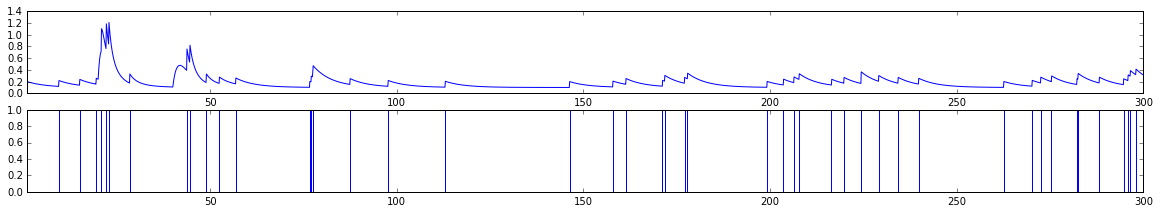

In [7]:
htrm.plot()

In [11]:
#htrm.fit_mle_params(tol=1e-18)
htrm.add_realization("train",T[:30])
htrm.set_cur_realization_key("train")
htrm.fit_em_map_params()
print htrm


 [-----------------100%-----------------] 1000 of 1000 complete in 23.9 sec
 iteration: 0
1.27803948491 0.84235461762 0.141851421357 0.401544538088 2.85268935394 0.938329578573 0.123391419121 0.876608580879
 [-----------------100%-----------------] 1000 of 1000 complete in 23.2 sec
 iteration: 1
2.46080532676 0.851136031541 0.142622468398 0.105035928628 1.39996963201 0.955470862799 0.0697910568406 0.930208943159
 [-----------------100%-----------------] 1000 of 1000 complete in 22.9 sec
 iteration: 2
2.74229072924 1.00667372757 0.143936882999 0.0452484927322 0.930463983753 0.96261908806 0.0463748223198 0.95362517768
 [-----------------100%-----------------] 1000 of 1000 complete in 23.0 sec
 iteration: 3
2.72914509715 0.832884327236 0.140324535045 0.0501714466798 0.933065852702 0.970884956893 0.0510267935435 0.948973206456
 [-----------------100%-----------------] 1000 of 1000 complete in 22.8 sec
 iteration: 4
3.23533544258 0.769296864527 0.143174363356 0.0493198138423 0.964825779987 

/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 0.00110354321077 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 23.5 sec
 iteration: 19
4.21615509451 0.533655152026 0.140147852115 0.0250259260145 0.986272290677 0.933628288248 0.0247463365419 0.975253663458


/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 0.000107286497951 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 23.5 sec
 iteration: 20
4.18795036412 0.531168811485 0.139839274021 0.0252677477712 0.973142450663 0.933654553154 0.0253079824414 0.974692017559
 [                  2%                  ] 23 of 1000 complete in 0.5 sec

/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of -0.00125805544667 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of -0.829580012709 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 24.3 sec
 iteration: 21
4.16081694085 0.531515100927 0.1396734662 0.0249518160457 0.969009277183 0.933672381067 0.0251034132178 0.974896586782


/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of -0.000408180756494 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 34.2651518583 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 24.2 sec
 iteration: 22
4.14866678379 0.528516517392 0.139754593739 0.025350274959 0.983125192555 0.933723551536 0.0251372252232 0.974862774777


/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of -106.10217008 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 2.33230386554e+13 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 23.4 sec
 iteration: 23
4.12584046177 0.528830615215 0.139753064019 0.0233811829616 0.978344180756 0.933723389153 0.0233409113999 0.9766590886
 [                  2%                  ] 22 of 1000 complete in 0.5 sec

/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 4.14744911691e+13 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7183648776.95 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 24.0 sec
 iteration: 24
4.15490252499 0.530701581116 0.139753041508 0.024219787449 0.978026758053 0.933723696955 0.0241654985569 0.975834501443


/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8249032553.14 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7184007959.39 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 23.7 sec
 iteration: 25
4.10652858599 0.527696328771 0.13975303284 0.0242422746629 0.976744901973 0.933723841673 0.024218366857 0.975781633143


/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8249445004.77 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7184367159.78 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 23.8 sec
 iteration: 26
4.1425204002 0.527343029024 0.139753033365 0.0236834416434 0.974976621658 0.933723734319 0.023715218535 0.976284781465


/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8249857477.02 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7184726378.14 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 23.6 sec
 iteration: 27
4.12006996468 0.527433290085 0.139753008879 0.0227070458141 0.976300340666 0.93372371067 0.0227296075299 0.97727039247
 [                  2%                  ] 20 of 1000 complete in 0.5 sec

/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8250269969.89 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7185085614.47 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 23.7 sec
 iteration: 28
4.08778096303 0.526634773058 0.13975302849 0.0215447274935 0.978343480358 0.933723797477 0.0215471362941 0.978452863706
 [                  2%                  ] 23 of 1000 complete in 0.5 sec

/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8250682483.39 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7185444868.75 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 23.9 sec
 iteration: 29
4.03024845422 0.526190849014 0.139753036009 0.0212977422011 0.976927305264 0.933723694918 0.0213356118995 0.978664388101


/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8251095017.52 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7185804140.98 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 0.00010010326514 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 23.5 sec
 iteration: 30
4.07460330182 0.526348297816 0.139753046173 0.0219125847446 0.981902530196 0.933723789239 0.0218293034429 0.978170696557


/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8251507572.27 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7186163431.2 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 49171.8258114 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 23.4 sec
 iteration: 31
4.16652131527 0.526341184325 0.139753080864 0.0218615908912 0.977012114067 0.933723585103 0.0218862412562 0.978113758744


/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8251920147.64 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7186522739.38 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 1.23394438042e+12 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 23.4 sec
 iteration: 32
4.12640792022 0.526341190856 0.139753063002 0.0222053007844 0.979061113432 0.933723433988 0.0221772152438 0.977822784756
 [                  2%                  ] 23 of 1000 complete in 0.5 sec

/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8252332743.64 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7186882065.5 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 17312879281.0 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 23.8 sec
 iteration: 33
4.13875178131 0.52634122843 0.139753062788 0.0224712627451 0.97947498508 0.93372347928 0.022427613052 0.977572386948
 [                  2%                  ] 21 of 1000 complete in 0.5 sec

/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8252745360.28 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7187241409.61 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 17313744925.0 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 23.9 sec
 iteration: 34
4.10782590833 0.526341282905 0.139753051697 0.022986464195 0.975576599528 0.933723627813 0.0230195418098 0.97698045819
 [                  2%                  ] 21 of 1000 complete in 0.5 sec

/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8253157997.55 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7187600771.67 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 17314610612.2 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 24.1 sec
 iteration: 35
4.07698117662 0.52634131603 0.139753065651 0.0229111440582 0.976137039065 0.933723675947 0.022932972048 0.977067027952


/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8253570655.45 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7187960151.72 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 17315476342.8 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1001 of 1000 complete in 23.5 sec
 iteration: 36
4.05798549205 0.526341323637 0.139753083456 0.023770103676 0.978463766133 0.933723829446 0.0237171227116 0.976282877288
 [                  2%                  ] 22 of 1000 complete in 0.5 sec

/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8253983333.98 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7188319549.72 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 17316342116.6 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 24.3 sec
 iteration: 37
4.02034384653 0.526341317441 0.139753093572 0.0238976164494 0.980010023456 0.933723768961 0.0238045966575 0.976195403342


/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 0.000862357206643 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8254396033.16 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7188678965.7 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 17317207933.7 reached
  warnings.warn(msg, RuntimeWarning)


 [-----------------100%-----------------] 1000 of 1000 complete in 23.8 sec
 iteration: 38
4.02752750799 0.5263413635 0.139753093548 0.0234640050176 0.975212884497 0.933723766757 0.0234950916197 0.97650490838
Converged
{'b_h': 0.976504908380317, 'a_s': 4.0275275079856891, 'r_0': 0.13975309354792539, 'kappa': 0.93372376675686086, 'b_s': 0.52634136350014238, 'a_h': 0.023495091619682999}


/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 2.13303700582e+12 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 8254808752.95 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 7189038399.66 reached
  warnings.warn(msg, RuntimeWarning)
/home/harit.vishwakarma/.h/miniconda2/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 17318073794.1 reached
  warnings.warn(msg, RuntimeWarning)


In [ ]:
#htrm.plot()
print htrm.log_likelihood()
print htrm.log_likelihood_1()


In [ ]:
#HTRm Sampling Demo
# Reproducing figures 3 A-E of the paper.
# Figure 3.A
%matplotlib inline
np.random.seed(0)
htrm = HTRm(a_s=0.0,b_s=1.0,r_0=0.1,kappa=1.0,a_h=0.0,b_h=1.0,T_s=[])

T = htrm.sample(n_samples=100,t_0=1.0)
htrm.plot()
print htrm.log_likelihood_1()
print htrm.coef_variation()
print htrm.iei_corr()



In [ ]:
# Figure 3.B
%matplotlib inline

import numpy as np

np.random.seed(0)
#params = {"a_s":0.0, "b_s":1.0, "r_0":0.1, "t_0":1.0, "kappa":1.0, "a_h":1.5, "b_h":2.0,"T_s":T_s}
htrm = HTRm(a_s=0.0,b_s=1.0,r_0=0.1,kappa=3.0,a_h=0.0,b_h=1.0,T_s=[])

T = htrm.sample(n_samples=100,t_0=1.0)
htrm.plot()
print htrm.log_likelihood()
print htrm.coef_variation()
print htrm.iei_corr()


In [ ]:
# Figure 3.C
%matplotlib inline

import numpy as np

np.random.seed(0)

htrm = HTRm(a_s=0.0,b_s=1.0,r_0=0.1,kappa=0.7,a_h=0.0,b_h=1.0,T_s=[])

T = htrm.sample(n_samples=100,t_0=1.0)

htrm.plot()
print htrm.coef_variation()
print htrm.iei_corr()



In [ ]:
#Figure 3D
np.random.seed(0)
htrm = HTRm(a_s=0.0,b_s=1.0,r_0=0.1,kappa=1.0,a_h=1.5,b_h=2.0,T_s=[])
T = htrm.sample(n_samples=100,t_0=1.0)

htrm.plot()

print htrm.coef_variation()
print htrm.iei_corr()

In [ ]:
#Fig 3E
np.random.seed(0)
htrm = HTRm(a_s=0.0,b_s=1.0,r_0=0.1,kappa=1.5,a_h=1.8,b_h=4.0,T_s=[])
T = htrm.sample(n_samples=100,t_0=1.0)
htrm.plot()
print htrm.log_likelihood_1()
print htrm.coef_variation()
print htrm.iei_corr()


In [ ]:
#Fig 3F
htrm = HTRm(a_s=2.0,b_s=0.5,r_0=0.1,kappa=1.0,a_h=0.0,b_h=4.0,T_s=[20,160])
T = htrm.sample(n_samples=50,t_0=1.0)

htrm.plot()
print htrm.log_likelihood_1()
print htrm.coef_variation()
print htrm.iei_corr()

In [ ]:
class X:
    def __init__(self,x=5):
        self.x = x
    def a(self):
        z = 20
        def b(y=6):
            print self.x+y
            print z
            print d
            #z = 5
        d = 5
        b()
        d = 30
        b()
        print z
xx = X()
xx.x = 6
xx.a()